<a href="https://colab.research.google.com/github/tronglinux123/AI-Project/blob/main/Evaluation_SMOTE_and_XGBClassifier_XGBRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip freeze | grep scikit

scikit-image==0.25.2
scikit-learn==1.6.1


In [1]:
from google.cloud import bigquery
from google.colab import auth, drive
import os
# Mount to Google Drive if data on Drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/doan_demo')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/doan_demo'

In [2]:
from typing import Callable
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import warnings
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import gc
warnings.filterwarnings('ignore')



In [3]:
df = pd.read_csv('x_ray_and_features_data.csv')

diseases = ['pneumonia', 'tuberculosis', 'bronchitis', 'arthritis', 'fracture', 'lung_cancer', 'scoliosis', 'lung_infection']
mimic_feats = ['diabete', 'age', 'hiv', 'oxygen', 'heart_rate', 'temperature', 'hemoglobin', 'rbc', 'wbc', 'smoke', 'cough']
img_feats = [str(x) for x in range(18)]
models = [XGBClassifier]
# Keep the necessary data
data = df[img_feats+mimic_feats]

In [ ]:
data

,0,1,2,3,4,5,6,7,8,9,...,age,hiv,oxygen,heart_rate,temperature,hemoglobin,rbc,wbc,smoke,cough
0,-1.920675,-3.472368,3.423497e-39,-4.019975,-2.682965,3.095561e-39,2.350940e-40,-2.235377,-4.163281,-4.595403e-39,...,50,0,NaN,NaN,NaN,11.9,4.40,5.5,0,0
1,0.088068,-1.032863,2.666148e-39,-3.083943,-0.214080,1.675793e-39,-5.305300e-40,0.470033,-1.843389,-2.014102e-39,...,76,0,NaN,NaN,NaN,12.1,3.86,9.3,0,0
2,-0.521883,-0.844022,1.648815e-39,-2.451156,0.017114,-9.188970e-40,2.053338e-39,-0.687770,-1.140900,1.666720e-39,...,76,0,NaN,NaN,NaN,12.1,3.86,9.3,0,0
3,0.401914,-1.997322,-4.848840e-40,-3.875956,-0.883333,-1.451999e-39,-8.226740e-40,-0.259665,-1.303978,8.319800e-41,...,76,0,NaN,NaN,NaN,12.1,3.86,9.3,0,0
4,-1.056595,-4.040716,1.544811e-39,-4.820945,-2.704534,-7.036560e-40,-1.042745e-39,-2.362798,-2.435506,-2.722800e-39,...,56,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29078,-3.728611,-4.977847,3.031653e-39,-5.108873,-5.318205,1.355334e-39,-1.813954e-39,-3.791145,-5.012530,-1.308602e-38,...,32,1,NaN,NaN,NaN,6.6,2.45,2.4,0,0
29079,-2.983252,-4.527564,3.047530e-40,-5.296632,-4.274313,1.801090e-39,3.243934e-39,-3.313225,-4.193819,-8.045227e-39,...,32,1,NaN,NaN,NaN,6.6,2.45,2.4,0,0
29080,0.508512,-1.068828,5.612754e-39,-3.753665,-0.220833,2.278004e-39,1.523423e-39,0.121205,-3.017588,2.945640e-40,...,32,1,NaN,NaN,NaN,6.6,2.45,2.4,0,0
29081,-0.743946,-2.159284,-4.178940e-40,-4.024840,-0.524709,-2.100615e-39,1.569922e-39,-0.918786,-3.664216,1.304308e-39,...,32,1,NaN,NaN,NaN,6.6,2.45,2.4,0,0


In [ ]:
def classify_and_compare(clf: Callable, d, l,
                         test:float = 0.35,
                         verbose:int = 0,
                         print_res:bool = False,
                         df = None,
                         engineering:str = 'None',
                         disease:str = 'None'):
  r'''
  Compare data with and without additional MIMIC-IV Features

  Params
  ---
  - `clf`: The classifier initialization function (sklearn style)
  - `d`: dataset that contains both MIMIC-IV and image data features
  - `l`: label data
  - `test`: test split ratio
  - `verbose`: If you want to print out the progress in the classfier while fitting
  - `print_res`: If result is to be printed or exported to a dataframe column
  - `df`: the dataframe to append results to if not printing
  - `engineering`: Specify if any data engineering is done
  - `disease`: Name of the disease being classified
  '''
  # Split to train and test
  xtr, xte, ytr, yte = train_test_split(d, l, test_size=test)

  # c1: With all features
  b = clf().fit(xtr,ytr)
  p = b.predict(xte)
  c1 = classification_report(yte, p, output_dict = not print_res)

  # c2: Image features only
  b = clf().fit(xtr[img_feats],ytr)
  p = b.predict(xte[img_feats])
  c2 = classification_report(yte, p, output_dict = not print_res)

  # c3: Original structure: a linear layer with sigmoid activation on image features
  b = LogisticRegression().fit(xtr[img_feats],ytr)
  p = b.predict(xte[img_feats])
  c3 = classification_report(yte, p, output_dict = not print_res)

  # Either print result or append to dataframe
  if print_res:
    print(c1 + '\n' + c2 + '\n' + c3)
  else:
    col = pd.Series({'Model': clf.__name__,
                     'Engineering': engineering,
                     'Disease': disease,
                     # Accuracy
                     'acc_e': c1['accuracy'],
                     'acc_o': c2['accuracy'],
                     'acc_d': c1['accuracy'] - c2['accuracy'],
                     'acc_i': c2['accuracy'] - c3['accuracy'],
                     'acc_x': c1['accuracy'] - c3['accuracy'],
                     # Precision for negative
                     'p0_e': c1['0']['precision'],
                     'p0_o': c2['0']['precision'],
                     'p0_d': c1['0']['precision'] - c2['0']['precision'],
                     # Precision for positive
                     'p1_e': c1['1']['precision'],
                     'p1_o': c2['1']['precision'],
                     'p1_d': c1['1']['precision'] - c2['1']['precision'],
                     'p1_i': c2['1']['precision'] - c3['1']['precision'],
                     'p1_x': c1['1']['precision'] - c3['1']['precision'],
                     # Recall for negative
                     'r0_e': c1['0']['recall'],
                     'r0_o': c2['0']['recall'],
                     'r0_d': c1['0']['recall'] - c2['0']['recall'],
                     # Recall for positive
                     'r1_e': c1['1']['recall'],
                     'r1_o': c2['1']['recall'],
                     'r1_d': c1['1']['recall'] - c2['1']['recall'],

                     })
    df[len(df.columns)] = col

In [ ]:
def classify_and_compare_SMOTE(clf: Callable, d, l,
                         test:float = 0.35,
                         verbose:int = 0,
                         print_res:bool = False,
                         df = None,
                         engineering:str = 'None',
                         disease:str = 'None'):
  r'''
  Compare data with and without additional MIMIC-IV Features

  Params
  ---
  - `clf`: The classifier initialization function (sklearn style)
  - `d`: dataset that contains both MIMIC-IV and image data features
  - `l`: label data
  - `test`: test split ratio
  - `verbose`: If you want to print out the progress in the classfier while fitting
  - `print_res`: If result is to be printed or exported to a dataframe column
  - `df`: the dataframe to append results to if not printing
  - `engineering`: Specify if any data engineering is done
  - `disease`: Name of the disease being classified
  '''
  # Split to train and test
  xtr, xte, ytr, yte = train_test_split(d, l, test_size=test)
  xtr = xtr.reset_index(drop=True)
  ytr = ytr.reset_index(drop=True)

  full_feats = img_feats + mimic_feats
  cat_feats = ['diabete', 'hiv', 'smoke', 'cough']
  sm = SMOTE(sampling_strategy=1, random_state=42)
  xtr_img_sm, ytr_sm = sm.fit_resample(xtr[img_feats], ytr)
  n_original = len(xtr)
  n_total = len(xtr_img_sm)
  n_synthetic = n_total - n_original

  xtr_final = pd.DataFrame()
  xtr_final[img_feats] = xtr_img_sm
  xtr_final.loc[:n_original-1, mimic_feats] = xtr[mimic_feats].values
  xtr_final.loc[n_original:, mimic_feats] = np.nan
  X_train_final = xtr_final
  y_train_final = ytr_sm
  # print('x_train_final')
  # print(X_train_final)
  # print('y_train_final')
  # print(y_train_final)
  X_train_img = xtr[img_feats]
  X_train_labels = xtr[cat_feats]
  X_synth_img = X_train_final.loc[n_original:, img_feats]
  models_cat = {}
  for col in cat_feats:
      mask = X_train_labels[col]
      n_pos = mask.sum()
      n_neg = len(mask) - n_pos
      model = XGBClassifier(
          n_estimators=200,
          max_depth=4,
          learning_rate=0.05,
          subsample=0.8,
          colsample_bytree=0.8,
          random_state=42,
          scale_pos_weight = n_neg / n_pos
      )

      model.fit(X_train_img, X_train_labels[col])
      models_cat[col] = model
  preds = {}
  for col in cat_feats:
      preds[col] = models_cat[col].predict(X_synth_img)
  for col in cat_feats:
      X_train_final.loc[n_original:, col] = preds[col]
  mimic_numeric = ['oxygen', 'heart_rate', 'temperature',
                   'hemoglobin', 'rbc', 'wbc']
  # print('x_train_final_V2')
  # print(X_train_final)
  # print('y_train_final_V2')
  # print(y_train_final)
  models_mask = {}
  models_value = {}

  for num in mimic_numeric:
    mask = xtr[num].notna().astype(int)
    n_pos = mask.sum()
    n_neg = len(mask) - n_pos
    X_train_num_input = pd.concat([X_train_img, X_train_labels], axis=1)

    # model mask (classifier)
    mask_model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight = n_neg / n_pos
    )

    mask_model.fit(X_train_num_input, mask)
    models_mask[num] = mask_model

    # model value (regression)
    value_model = XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    value_model.fit(X_train_num_input[mask == 1], xtr.loc[mask == 1, num])
    models_value[num] = value_model

  # mimic_age = ['diabete', 'hiv', 'oxygen', 'heart_rate', 'temperature', 'hemoglobin', 'rbc', 'wbc', 'smoke', 'cough']
  # X_train_age = xtr[img_feats + mimic_age]
  # y_train_age = xtr['age']
  # age_model = XGBRegressor(
  #     n_estimators=200,
  #     max_depth=4,
  #     learning_rate=0.05,
  #     subsample=0.8,
  #     colsample_bytree=0.8,
  #     random_state=42
  # )

  # age_model.fit(X_train_age, y_train_age)
  # X_synth_age_input = X_train_final.loc[n_original:, img_feats + mimic_age]
  # age_pred = age_model.predict(X_synth_age_input)

  # X_train_final.loc[n_original:, 'age'] = age_pred

  X_synth_input = pd.concat([X_synth_img, X_train_final.loc[n_original:, cat_feats]], axis=1)

  for num in mimic_numeric:
      mask_pred = models_mask[num].predict(X_synth_input)
      idx_has_value = (mask_pred == 1)

      if idx_has_value.sum() > 0:
          values = models_value[num].predict(X_synth_input[idx_has_value])
          X_train_final.loc[n_original:].loc[idx_has_value, num] = values
  # print('x_train_final_V3')
  # print(X_train_final)
  # print('y_train_final_V3')
  # print(y_train_final)
  # c1: With all features
  # print("train Số lớp 0 V1:", (ytr == 0).sum())
  # print("train Số lớp 1 V1:", (ytr == 1).sum())
  # print("train Số lớp 0 V2:", (y_train_final == 0).sum())
  # print("train Số lớp 1 V2:", (y_train_final == 1).sum())
  # print("Test Số lớp 0:", (yte == 0).sum())
  # print("Test Số lớp 1:", (yte == 1).sum())


  b = clf().fit(X_train_final,y_train_final)
  p = b.predict(xte)
  c1 = classification_report(yte, p, output_dict = not print_res)

  # c2: Image features only
  b = clf().fit(X_train_final[img_feats],y_train_final)
  p = b.predict(xte[img_feats])
  c2 = classification_report(yte, p, output_dict = not print_res)

  # c3: Original structure: a linear layer with sigmoid activation on image features
  b = LogisticRegression().fit(X_train_final[img_feats],y_train_final)
  p = b.predict(xte[img_feats])
  c3 = classification_report(yte, p, output_dict = not print_res)

  # Either print result or append to dataframe
  if print_res:
    print(c1 + '\n' + c2 + '\n' + c3)
  else:
    col = pd.Series({'Model': clf.__name__,
                     'Engineering': engineering,
                     'Disease': disease,
                     # Accuracy
                     'acc_e': c1['accuracy'],
                     'acc_o': c2['accuracy'],
                     'acc_d': c1['accuracy'] - c2['accuracy'],
                     'acc_i': c2['accuracy'] - c3['accuracy'],
                     'acc_x': c1['accuracy'] - c3['accuracy'],
                     # Precision for negative
                     'p0_e': c1['0']['precision'],
                     'p0_o': c2['0']['precision'],
                     'p0_d': c1['0']['precision'] - c2['0']['precision'],
                     # Precision for positive
                     'p1_e': c1['1']['precision'],
                     'p1_o': c2['1']['precision'],
                     'p1_d': c1['1']['precision'] - c2['1']['precision'],
                     'p1_i': c2['1']['precision'] - c3['1']['precision'],
                     'p1_x': c1['1']['precision'] - c3['1']['precision'],
                     # Recall for negative
                     'r0_e': c1['0']['recall'],
                     'r0_o': c2['0']['recall'],
                     'r0_d': c1['0']['recall'] - c2['0']['recall'],
                     # Recall for positive
                     'r1_e': c1['1']['recall'],
                     'r1_o': c2['1']['recall'],
                     'r1_d': c1['1']['recall'] - c2['1']['recall'],

                    #  'acc_L': c3['accuracy'],
                    #  'p0_L': c3['0']['precision'],
                    #  'p1_L': c3['1']['precision'],
                    #  'r0_L': c3['0']['recall'],
                    #  'r1_L': c3['1']['recall']

                     })
    df[len(df.columns)] = col

In [ ]:
# Number of times run per model
n_iter = 5
# Desired test size
test_size = 0.35
res = pd.DataFrame()

# For each group of disease and model, perform n comparison runs
for d in tqdm.tqdm(diseases):
  l = df[d]
  for m in models:
    for i in range(n_iter):
      classify_and_compare(m, data, l, test_size, df=res, engineering='None', disease=d)

res.T

100%|██████████| 8/8 [01:02<00:00,  7.77s/it]


,Model,Engineering,Disease,acc_e,acc_o,acc_d,p0_e,p0_o,p0_d,p1_e,p1_o,p1_d,r0_e,r0_o,r0_d,r1_e,r1_o,r1_d
0,XGBClassifier,None,pneumonia,0.781434,0.701965,0.07947,0.797887,0.732604,0.065283,0.684103,0.325945,0.358158,0.937272,0.930258,0.007015,0.363932,0.090351,0.273581
1,XGBClassifier,None,pneumonia,0.787033,0.711297,0.075737,0.802885,0.73979,0.063095,0.691136,0.354582,0.336554,0.940214,0.934853,0.005362,0.366912,0.098162,0.26875
2,XGBClassifier,None,pneumonia,0.786051,0.702259,0.083792,0.799908,0.731508,0.0684,0.704852,0.338177,0.366675,0.940763,0.932242,0.00852,0.375449,0.091888,0.283561
3,XGBClassifier,None,pneumonia,0.785855,0.698232,0.087623,0.796733,0.730655,0.066078,0.715543,0.303109,0.412434,0.947652,0.927415,0.020237,0.352601,0.084538,0.268064
4,XGBClassifier,None,pneumonia,0.786346,0.706189,0.080157,0.799197,0.732382,0.066814,0.709898,0.359441,0.350457,0.94249,0.938024,0.004465,0.37276,0.092115,0.280645
5,XGBClassifier,None,tuberculosis,0.978291,0.973379,0.004912,0.978471,0.973664,0.004808,0.944444,0.25,0.694444,0.999697,0.999697,0.0,0.189591,0.003717,0.185874
6,XGBClassifier,None,tuberculosis,0.977996,0.972692,0.005305,0.978074,0.973071,0.005003,0.963636,0.2,0.763636,0.999798,0.999596,0.000202,0.192727,0.003636,0.189091
7,XGBClassifier,None,tuberculosis,0.977308,0.971709,0.005599,0.977192,0.972187,0.005005,1.0,0.0,1.0,1.0,0.999495,0.000505,0.183746,0.0,0.183746
8,XGBClassifier,None,tuberculosis,0.977898,0.972299,0.005599,0.978343,0.972394,0.005948,0.911765,0.0,0.911765,0.999394,0.999899,-0.000505,0.220641,0.0,0.220641
9,XGBClassifier,None,tuberculosis,0.97888,0.973576,0.005305,0.978959,0.973671,0.005288,0.964912,0.0,0.964912,0.999798,0.999899,-0.000101,0.205224,0.0,0.205224


In [ ]:
# Number of times run per model
n_iter = 5
# Desired test size
test_size = 0.35
res = pd.DataFrame()

# For each group of disease and model, perform n comparison runs
for d in tqdm.tqdm(diseases):
  l = df[d]
  for m in models:
    for i in range(n_iter):
      classify_and_compare_SMOTE(m, data, l, test_size, df=res, engineering='None', disease=d)

res.T

100%|██████████| 8/8 [06:27<00:00, 48.47s/it]


,Model,Engineering,Disease,acc_e,acc_o,acc_d,acc_i,acc_x,p0_e,p0_o,...,p1_o,p1_d,p1_i,p1_x,r0_e,r0_o,r0_d,r1_e,r1_o,r1_d
0,XGBClassifier,None,pneumonia,0.791847,0.589194,0.202652,0.032613,0.235265,0.805783,0.754628,...,0.312139,0.399002,-0.011025,0.387977,0.941707,0.64755,0.294157,0.387355,0.431686,-0.044331
1,XGBClassifier,None,pneumonia,0.781631,0.591159,0.190472,0.040864,0.231336,0.799218,0.756676,...,0.314893,0.363268,-0.003181,0.360088,0.935935,0.648318,0.287618,0.364727,0.436727,-0.072
2,XGBClassifier,None,pneumonia,0.787917,0.583988,0.203929,0.033301,0.23723,0.802796,0.748953,...,0.299331,0.399224,-0.020261,0.378963,0.941161,0.648442,0.292719,0.37098,0.408626,-0.037646
3,XGBClassifier,None,pneumonia,0.788409,0.578684,0.209725,0.030845,0.24057,0.803619,0.750319,...,0.304592,0.396007,-0.01393,0.382077,0.939378,0.632763,0.306615,0.381937,0.433079,-0.051143
4,XGBClassifier,None,pneumonia,0.791061,0.575147,0.215914,0.032711,0.248625,0.804415,0.74459,...,0.296441,0.416304,-0.015887,0.400417,0.942603,0.635139,0.307464,0.383249,0.413706,-0.030457
5,XGBClassifier,None,tuberculosis,0.976326,0.890079,0.086248,0.322888,0.409136,0.976296,0.971902,...,0.037037,0.944781,-0.003008,0.941773,0.999899,0.913211,0.086688,0.183673,0.112245,0.071429
6,XGBClassifier,None,tuberculosis,0.980255,0.883104,0.097151,0.311984,0.409136,0.980253,0.976032,...,0.030969,0.9498,-0.002583,0.947217,0.999899,0.902306,0.097593,0.203187,0.123506,0.079681
7,XGBClassifier,None,tuberculosis,0.97554,0.877112,0.098428,0.309921,0.40835,0.975605,0.971479,...,0.037901,0.925735,0.000497,0.926232,0.999798,0.899798,0.1,0.176667,0.13,0.046667
8,XGBClassifier,None,tuberculosis,0.979175,0.879371,0.099804,0.314735,0.414538,0.979358,0.974762,...,0.029211,0.916243,-0.006002,0.910242,0.999698,0.899486,0.100212,0.199234,0.114943,0.084291
9,XGBClassifier,None,tuberculosis,0.979175,0.893418,0.085756,0.315619,0.401375,0.979447,0.976167,...,0.047409,0.885924,0.012799,0.898723,0.999597,0.912868,0.086729,0.212121,0.162879,0.049242


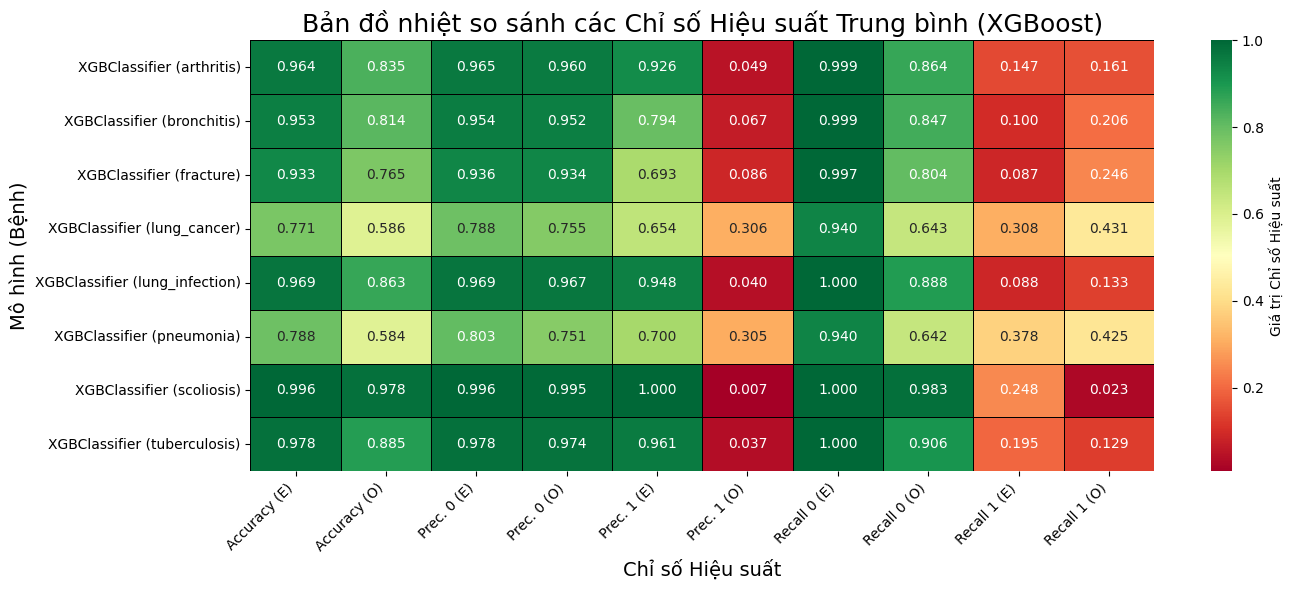

In [ ]:
#smote cũ
import io
res_T = res.T

csv_string = res_T.to_csv(index=True)

df_data = pd.read_csv(io.StringIO(csv_string))
mean_results = df_data.groupby(['Model', 'Disease']).mean().reset_index()


metrics_to_plot = [
    'acc_e', 'acc_o',
    'p0_e', 'p0_o',
    'p1_e', 'p1_o',
    'r0_e', 'r0_o',
    'r1_e', 'r1_o',
]

mean_results['Model_Disease'] = mean_results['Model'] + ' (' + mean_results['Disease'] + ')'

heatmap_df = mean_results.set_index('Model_Disease')[metrics_to_plot]

new_col_names = {
    'acc_e': 'Accuracy (E)', 'acc_o': 'Accuracy (O)',
    'p0_e': 'Prec. 0 (E)', 'p0_o': 'Prec. 0 (O)',
    'p1_e': 'Prec. 1 (E)', 'p1_o': 'Prec. 1 (O)',
    'r0_e': 'Recall 0 (E)', 'r0_o': 'Recall 0 (O)',
    'r1_e': 'Recall 1 (E)', 'r1_o': 'Recall 1 (O)',
}
heatmap_df.columns = heatmap_df.columns.map(new_col_names)


plt.figure(figsize=(14, 6))

sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".3f",
    cmap='RdYlGn',
    linewidths=.5,
    linecolor='black',
    cbar_kws={'label': 'Giá trị Chỉ số Hiệu suất'}
)

plt.title('Bản đồ nhiệt so sánh các Chỉ số Hiệu suất Trung bình (XGBoost)', fontsize=18)
plt.ylabel('Mô hình (Bệnh)', fontsize=14)
plt.xlabel('Chỉ số Hiệu suất', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

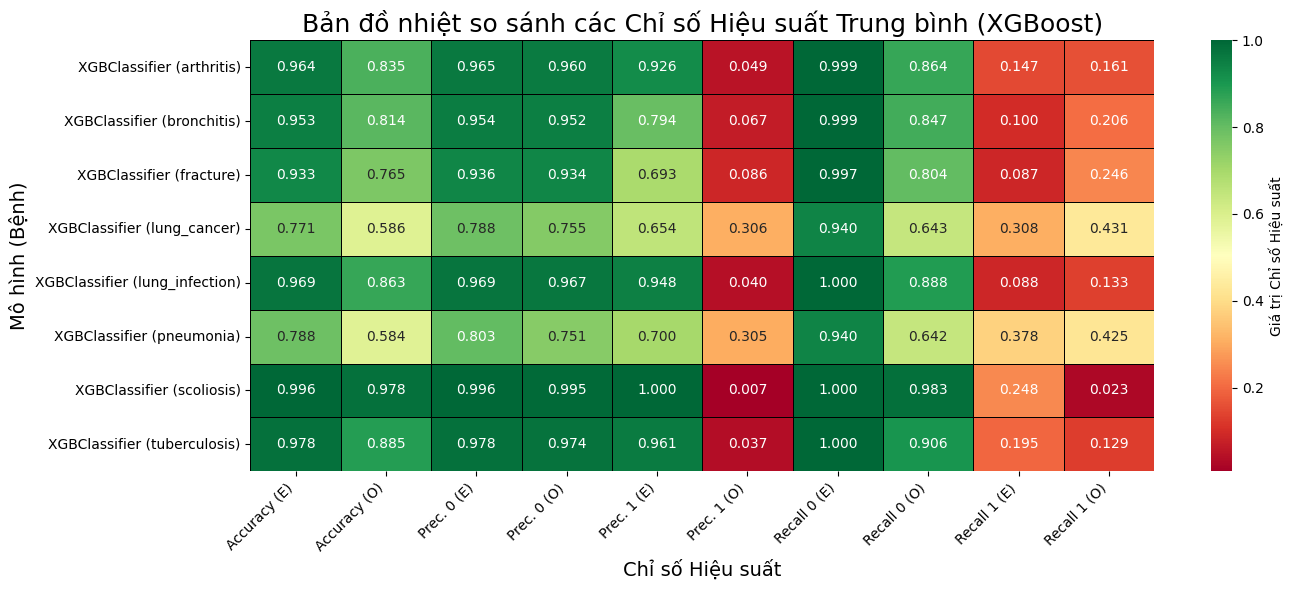

In [ ]:
#smote new
import io
res_T = res.T

csv_string = res_T.to_csv(index=True)

df_data = pd.read_csv(io.StringIO(csv_string))
mean_results = df_data.groupby(['Model', 'Disease']).mean().reset_index()


metrics_to_plot = [
    'acc_e', 'acc_o',
    'p0_e', 'p0_o',
    'p1_e', 'p1_o',
    'r0_e', 'r0_o',
    'r1_e', 'r1_o',
]

mean_results['Model_Disease'] = mean_results['Model'] + ' (' + mean_results['Disease'] + ')'

heatmap_df = mean_results.set_index('Model_Disease')[metrics_to_plot]

new_col_names = {
    'acc_e': 'Accuracy (E)', 'acc_o': 'Accuracy (O)',
    'p0_e': 'Prec. 0 (E)', 'p0_o': 'Prec. 0 (O)',
    'p1_e': 'Prec. 1 (E)', 'p1_o': 'Prec. 1 (O)',
    'r0_e': 'Recall 0 (E)', 'r0_o': 'Recall 0 (O)',
    'r1_e': 'Recall 1 (E)', 'r1_o': 'Recall 1 (O)',
}
heatmap_df.columns = heatmap_df.columns.map(new_col_names)


plt.figure(figsize=(14, 6))

sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".3f",
    cmap='RdYlGn',
    linewidths=.5,
    linecolor='black',
    cbar_kws={'label': 'Giá trị Chỉ số Hiệu suất'}
)

plt.title('Bản đồ nhiệt so sánh các Chỉ số Hiệu suất Trung bình (XGBoost)', fontsize=18)
plt.ylabel('Mô hình (Bệnh)', fontsize=14)
plt.xlabel('Chỉ số Hiệu suất', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

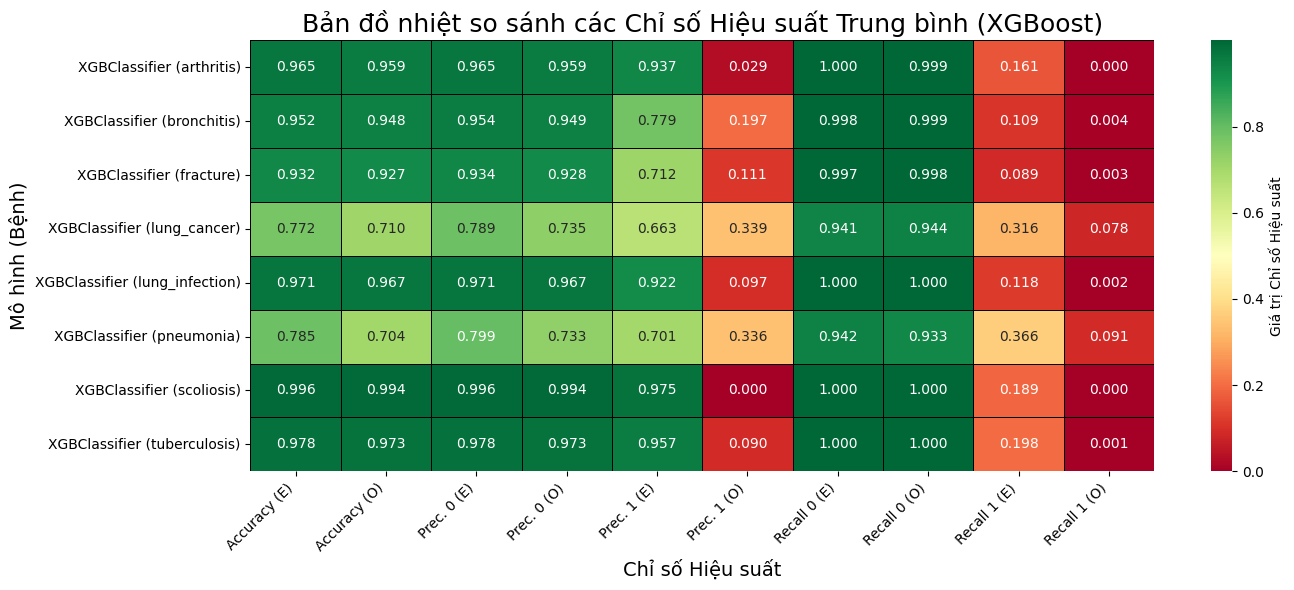

In [ ]:
#sensei
import io
res_T = res.T

csv_string = res_T.to_csv(index=True)

df_data = pd.read_csv(io.StringIO(csv_string))
mean_results = df_data.groupby(['Model', 'Disease']).mean().reset_index()


metrics_to_plot = [
    'acc_e', 'acc_o',
    'p0_e', 'p0_o',
    'p1_e', 'p1_o',
    'r0_e', 'r0_o',
    'r1_e', 'r1_o',
]

mean_results['Model_Disease'] = mean_results['Model'] + ' (' + mean_results['Disease'] + ')'

heatmap_df = mean_results.set_index('Model_Disease')[metrics_to_plot]

new_col_names = {
    'acc_e': 'Accuracy (E)', 'acc_o': 'Accuracy (O)',
    'p0_e': 'Prec. 0 (E)', 'p0_o': 'Prec. 0 (O)',
    'p1_e': 'Prec. 1 (E)', 'p1_o': 'Prec. 1 (O)',
    'r0_e': 'Recall 0 (E)', 'r0_o': 'Recall 0 (O)',
    'r1_e': 'Recall 1 (E)', 'r1_o': 'Recall 1 (O)',
}
heatmap_df.columns = heatmap_df.columns.map(new_col_names)


plt.figure(figsize=(14, 6))

sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".3f",
    cmap='RdYlGn',
    linewidths=.5,
    linecolor='black',
    cbar_kws={'label': 'Giá trị Chỉ số Hiệu suất'}
)

plt.title('Bản đồ nhiệt so sánh các Chỉ số Hiệu suất Trung bình (XGBoost)', fontsize=18)
plt.ylabel('Mô hình (Bệnh)', fontsize=14)
plt.xlabel('Chỉ số Hiệu suất', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()